<a href="https://colab.research.google.com/github/timomo3/sem_seg_pytorch/blob/master/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1AdMbVK110IKLG7wJKhga2N2fitV1bVPA

Downloading...
From: https://drive.google.com/uc?id=1AdMbVK110IKLG7wJKhga2N2fitV1bVPA
To: /content/drinks.tar.gz
147MB [00:02, 51.6MB/s]


In [2]:
!tar -xvf  'drinks.tar.gz'

drinks/
drinks/0010010.jpg
drinks/0000203.jpg
drinks/0000565.jpg
drinks/0000571.jpg
drinks/0010004.jpg
drinks/0000217.jpg
drinks/0000559.jpg
drinks/0010038.jpg
drinks/0000767.jpg
drinks/0000001.jpg
drinks/0000015.jpg
drinks/0000773.jpg
drinks/0000983.jpg
drinks/0000029.jpg
drinks/0000997.jpg
drinks/0000968.jpg
drinks/0000940.jpg
drinks/0000798.jpg
drinks/0000954.jpg
drinks/0000613.jpg
drinks/0000175.jpg
drinks/0000161.jpg
drinks/0000607.jpg
drinks/0000149.jpg
drinks/0000808.jpg
drinks/0000834.jpg
drinks/0000820.jpg
drinks/0000377.jpg
drinks/0000411.jpg
drinks/0000405.jpg
drinks/0000363.jpg
drinks/0000439.jpg
drinks/._0000388.jpg
drinks/0000388.jpg
drinks/0000389.jpg
drinks/0000438.jpg
drinks/0000404.jpg
drinks/0000362.jpg
drinks/0000376.jpg
drinks/0000410.jpg
drinks/0000821.jpg
drinks/0000835.jpg
drinks/0000809.jpg
drinks/0000148.jpg
drinks/0000160.jpg
drinks/0000606.jpg
drinks/0000612.jpg
drinks/0000174.jpg
drinks/0000955.jpg
drinks/0000799.jpg
drinks/0000941.jpg
drinks/0000969.jpg
dr

In [0]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets, models

import numpy as np
import os
import skimage
from skimage.io import imread

class DataGenerator(Dataset):
    """Multi-threaded data generator.
    Each thread reads a batch of images and their object labels.
    A label is a pixel-wise semantic mask.
    """
    def __init__(self, root_dir):
        self.input_shape = (480, #height
                            640, #width
                            3) #channel
        self.root_dir = root_dir
        self.get_dictionary()
        


    def get_dictionary(self):
        """Load ground truth dictionary of 
            image filename : segmentation masks
        """
        path = os.path.join('drinks', #datapath
                            self.root_dir) #labels.npy
        self.dictionary = np.load(path,
                                  allow_pickle=True).flat[0]
        self.keys = np.array(list(self.dictionary.keys()))
        labels = self.dictionary[self.keys[0]]
        self.n_classes = labels.shape[-1]


    def __len__(self):
        """Number of batches per epoch"""
        blen = np.floor(len(self.dictionary))
        return int(blen)


    def __getitem__(self, index):
        """Get a batch of data"""
        start_index = index
        end_index = (index+1)
        keys = self.keys[start_index : end_index]
        x, y = self.__data_generation(keys)
        x = x[0,:, :, :]
        y = y[0,:, :, :]
        x = np.float32(x)
        y = np.float32(y)
        return x.transpose((2,0,1)), y.transpose((2,0,1))


    def __data_generation(self, keys):
        """Generate train data: images and 
        segmentation ground truth labels 

        Arguments:
            keys (array): Randomly sampled keys
                (key is image filename)

        Returns:
            x (tensor): Batch of images
            y (tensor): Batch of pixel-wise categories
        """
        # a batch of images
        x = []
        # and their corresponding segmentation masks
        y = []

        for i, key in enumerate(keys):
            # images are assumed to be stored 
            # in self.args.data_path
            # key is the image filename 
            image_path = os.path.join('drinks', key) #datapath
            image = skimage.img_as_float(imread(image_path))
            # append image to the list
            x.append(image)
            # and its corresponding label (segmentation mask)
            labels = self.dictionary[key]
            y.append(labels)

        return np.array(x), np.array(y)

In [2]:
batch_size = 2

dataset = DataGenerator(root_dir = 'segmentation_train.npy')
train_set, val_set = random_split(dataset, [900,100])

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(dataloaders[x]) for x in dataloaders.keys()
}

dataset_sizes

{'train': 450, 'val': 50}

torch.FloatTensor
torch.Size([2, 3, 480, 640]) torch.Size([2, 4, 480, 640])


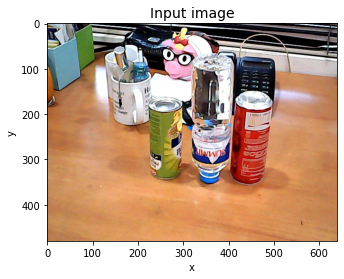

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


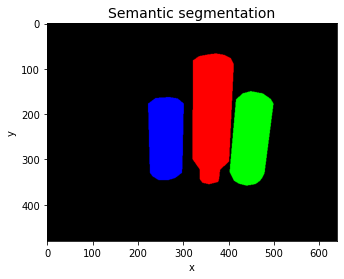

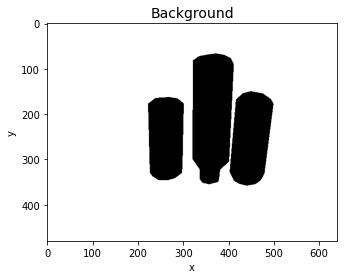

In [3]:
import torchvision.utils
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

images = inputs.permute((0,2,3,1))
labels = masks.permute((0,2,3,1))

print(inputs.type())
print(inputs.shape, masks.shape)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Input image', fontsize=14)
plt.imshow(images[0])
plt.show()

labels = labels * 255
masks = labels[..., 1:]
bgs = labels[..., 0]

plt.xlabel('x')
plt.ylabel('y')
plt.title('Semantic segmentation', fontsize=14)
plt.imshow(masks[0])
plt.show()

shape = (bgs[0].shape[0], bgs[0].shape[1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Background', fontsize=14)
plt.imshow(np.reshape(bgs[0], shape), cmap='gray', vmin=0, vmax=255)
plt.show()

In [4]:
from torchvision import models

base_model = models.resnet18(pretrained=False)

# check keras-like model summary using torchsummary
import torch
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

summary(base_model, input_size=(3, 480, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 320]           9,408
       BatchNorm2d-2         [-1, 64, 240, 320]             128
              ReLU-3         [-1, 64, 240, 320]               0
         MaxPool2d-4         [-1, 64, 120, 160]               0
            Conv2d-5         [-1, 64, 120, 160]          36,864
       BatchNorm2d-6         [-1, 64, 120, 160]             128
              ReLU-7         [-1, 64, 120, 160]               0
            Conv2d-8         [-1, 64, 120, 160]          36,864
       BatchNorm2d-9         [-1, 64, 120, 160]             128
             ReLU-10         [-1, 64, 120, 160]               0
       BasicBlock-11         [-1, 64, 120, 160]               0
           Conv2d-12         [-1, 64, 120, 160]          36,864
      BatchNorm2d-13         [-1, 64, 120, 160]             128
             ReLU-14         [-1, 64, 1

In [0]:
import torch

class FCN(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        layers = list(base_model.children())
        self.layer1 = nn.Sequential(*layers[:5]) # size=(N, 64, x.H/2, x.W/2)
        self.upsample1 = nn.Upsample(scale_factor=4, mode='bilinear')
        self.layer2 = layers[5]  # size=(N, 128, x.H/4, x.W/4)
        self.upsample2 = nn.Upsample(scale_factor=8, mode='bilinear')
        self.layer3 = layers[6]  # size=(N, 256, x.H/8, x.W/8)
        self.upsample3 = nn.Upsample(scale_factor=16, mode='bilinear')
        self.layer4 = layers[7]  # size=(N, 512, x.H/16, x.W/16)
        self.upsample4 = nn.Upsample(scale_factor=32, mode='bilinear')
        
        self.conv1k = nn.Conv2d(64 + 128 + 256 + 512, n_class, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer1(x)
        up1 = self.upsample1(x)
        x = self.layer2(x)
        up2 = self.upsample2(x)
        x = self.layer3(x)
        up3 = self.upsample3(x)
        x = self.layer4(x)
        up4 = self.upsample4(x)
        
        merge = torch.cat([up1, up2, up3, up4], dim=1)
        merge = self.conv1k(merge)
        out = self.sigmoid(merge)
        
        return out

In [7]:
# check keras-like model summary using torchsummary

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(4)
model = model.to(device)

summary(model, input_size=(3, 480, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 320]           9,408
       BatchNorm2d-2         [-1, 64, 240, 320]             128
              ReLU-3         [-1, 64, 240, 320]               0
         MaxPool2d-4         [-1, 64, 120, 160]               0
            Conv2d-5         [-1, 64, 120, 160]          36,864
       BatchNorm2d-6         [-1, 64, 120, 160]             128
              ReLU-7         [-1, 64, 120, 160]               0
            Conv2d-8         [-1, 64, 120, 160]          36,864
       BatchNorm2d-9         [-1, 64, 120, 160]             128
             ReLU-10         [-1, 64, 120, 160]               0
       BasicBlock-11         [-1, 64, 120, 160]               0
           Conv2d-12         [-1, 64, 120, 160]          36,864
      BatchNorm2d-13         [-1, 64, 120, 160]             128
             ReLU-14         [-1, 64, 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            epoch_steps = 20
            for i in range(epoch_steps):
                inputs, labels = next(iter(dataloaders['train']))

                inputs = inputs.to(device)
                labels = labels.to(device)                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / (batch_size * epoch_steps)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = FCN(4).to(device)

criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


train Loss: 0.2390
val Loss: 4.2680

Epoch 1/49
----------
train Loss: 0.1843
val Loss: 0.6462

Epoch 2/49
----------
train Loss: 0.1219
val Loss: 0.1053

Epoch 3/49
----------
train Loss: 0.0956
val Loss: 0.1237

Epoch 4/49
----------
train Loss: 0.1312
val Loss: 0.1400

Epoch 5/49
----------
train Loss: 0.1025
val Loss: 0.1836

Epoch 6/49
----------
train Loss: 0.1024
val Loss: 0.1494

Epoch 7/49
----------
train Loss: 0.0750
val Loss: 0.1757

Epoch 8/49
----------
train Loss: 0.0857
val Loss: 0.1665

Epoch 9/49
----------
train Loss: 0.0826
val Loss: 0.0839

Epoch 10/49
----------
train Loss: 0.0890
val Loss: 0.0787

Epoch 11/49
----------
train Loss: 0.0865
val Loss: 0.1062

Epoch 12/49
----------
train Loss: 0.0921
val Loss: 0.0955

Epoch 13/49
----------
train Loss: 0.0820
val Loss: 0.1316

Epoch 14/49
----------
train Loss: 0.0717
val Loss: 0.0924

Epoch 15/49
----------
train Loss: 0.0734
val Loss: 0.0701

Epoch 16/49
----------
train Loss: 0.0741
val Loss: 0.0897

Epoch 17/49


torch.FloatTensor
torch.Size([2, 3, 480, 640]) torch.Size([2, 4, 480, 640])


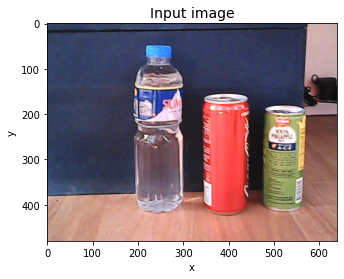

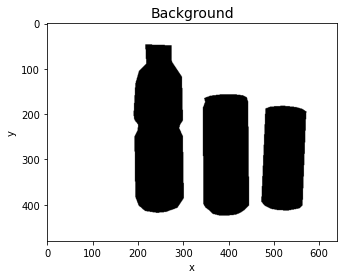

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


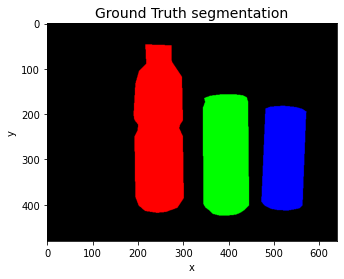

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(2, 4, 480, 640)


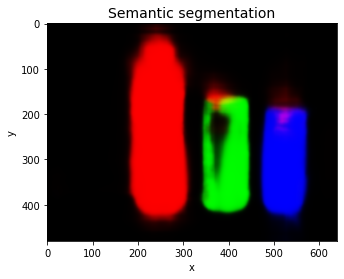

In [36]:
#### prediction

import math
import torch.nn.functional as F

model_ft.eval()   # Set model to evaluate mode

test_set = DataGenerator(root_dir = 'segmentation_test.npy')
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
        
inputs, masks = next(iter(test_loader))

images = inputs.permute((0,2,3,1))
labels = masks.permute((0,2,3,1))

print(inputs.type())
print(inputs.shape, masks.shape)

i = 0


plt.xlabel('x')
plt.ylabel('y')
plt.title('Input image', fontsize=14)
plt.imshow(images[i])
plt.savefig("input_image.png", bbox_inches='tight')
plt.show()

labels = labels * 255
masks = labels[..., 1:]
bgs = labels[..., 0]

shape = (bgs[i].shape[0], bgs[i].shape[1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Background', fontsize=14)
plt.imshow(np.reshape(bgs[i], shape), cmap='gray', vmin=0, vmax=255)
plt.savefig("background.png", bbox_inches='tight')
plt.show()

plt.xlabel('x')
plt.ylabel('y')
plt.title('Ground Truth segmentation', fontsize=14)
plt.imshow(masks[i])
plt.savefig("gt_segmentation.png", bbox_inches='tight')
plt.show()



inputs = inputs.to(device)
labels = labels.to(device)
pred = model_ft(inputs)
pred = pred.data.cpu().numpy()
print(pred.shape)

pred = pred.transpose((0,2,3,1))

pred_masks = pred[..., 1:]


plt.xlabel('x')
plt.ylabel('y')
plt.title('Semantic segmentation', fontsize=14)
plt.imshow(pred_masks[i])
plt.savefig("segmentation.png", bbox_inches='tight')
plt.show()
